## Install Dependencies

!pip3 install torch torchvision torchaudio

In [ ]:
!pip install 'stable-baselines3[extra]' 'protobuf==3.20.*'

In [ ]:
!pip install mss pydirectinput pytesseract

In [ ]:
!pip install pyautogui

In [ ]:
!pip install gymnasium

In [ ]:
!pip install py7zr

## Install necessary Libraries

In [59]:
from mss import mss
import pyautogui
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
print("done")

done


## Setup the webgame environment
* Note that we need to have the chrome dino game at chrome://dino up and available for the env to be able to capture the frames. Have the Jupyter notebook or other IDE open to the side of the webgame

In [60]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cv2
import pyautogui
import time
from mss import mss
import pytesseract

class WebGame(gym.Env):
    def __init__(self):
        super(WebGame, self).__init__()
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = spaces.Discrete(3)

        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 500, 'left': 400, 'width': 660, 'height': 70}

    def step(self, action):
        # 0 - space, 1 - duck (down), 2 - noop
        actions_dict = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        if action != 2:
            pyautogui.press(actions_dict[action])

        done, done_cap = self.get_done_text()
        new_obs = self.get_observation()

        reward = 1
        info = {}
        terminated = done
        truncated = False  # Set this according to your environment's logic
        return new_obs, reward, terminated, truncated, info

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    def reset(self, seed=None):
        self.seed(seed)
        time.sleep(1)
        pyautogui.click(x=500, y=500)
        pyautogui.press('space')
        return self.get_observation(), {}

    def close(self):
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.waitKey(1)

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))
        return channel

    def get_done_text(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        done_strings = ["GAME", "GAHE", "GARA", "GARM", "GAWM"]

        done = False
        result = pytesseract.image_to_string(done_cap)[:4]
        if result in done_strings:
            done = True
        return done, done_cap



## Test the webgame environment and image capture and tesseract conversion

In [61]:
env = WebGame()

In [62]:
done, done_cap = env.get_done_text()
print(done)

True


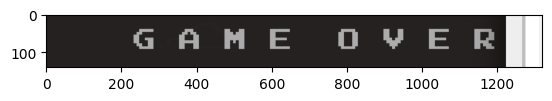

In [63]:
plt.imshow(done_cap)

In [64]:
pytesseract.image_to_string(done_cap)

'GAME OVER\n'

## Create a callback for learning

In [65]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker


In [66]:
env_checker.check_env(env)

In [67]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_frequency, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_frequency = check_frequency
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_frequency == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True
        

In [68]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [69]:
callback = TrainAndLoggingCallback(check_frequency=1000, save_path=CHECKPOINT_DIR)

## Create the DQN model and train it

In [70]:
from stable_baselines3 import DQN

In [ ]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, 
            buffer_size=200000, learning_starts=1000)

In [ ]:
# Training
model.learn(total_timesteps=250000, callback=callback)

## Load and test the model!
* ### This is the code to decompress the .7z file, load it as a .zip, and the final cell is the way to run the model for yourself in the browser!

In [76]:
compressed_filepath = os.path.join('train', 'best_model_250000.7z')
extracted_dir_path = os.path.join('train', 'final_model')
os.makedirs(extracted_dir_path, exist_ok=True)

In [80]:
import py7zr
with py7zr.SevenZipFile(compressed_filepath, mode='r') as z:
    z.extractall(path=extracted_dir_path)

print(f"Model files extracted to: {extracted_dir_path}")

Model files extracted to: train/final_model


In [81]:
model_path = os.path.join(extracted_dir_path, "best_model_250000")
loaded_model = DQN.load(model_path, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
for episode in range(3):
    observation, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = loaded_model.predict(observation)
        observation, reward, done, truncated, info = env.step(int(action))
        total_reward += reward

    print(f"Total Reward for Episode {episode} is {total_reward}")
